# Setup

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences, plot_history
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
import matplotlib.pyplot as plt
from TargetDistributions.MoG import Triangle_MoG
torch.set_default_dtype(torch.float64)

In [4]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
target = Triangle_MoG(loc_scaling=5, cov_scaling=1)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # print twice to make sure estimates are resonably close

tensor(63.8181)
tensor(63.8139)


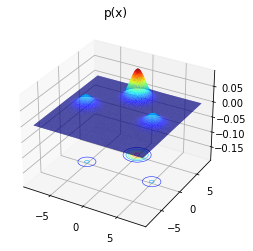

In [5]:
width = 8
fig = plot_distribution(target, bounds=[[-width, width], [-width, width]])

In [6]:
epochs = 1000
batch_size = int(1e2)
dim = 2
n_samples_estimation = int(1e6)
KPI_n_samples = int(1e4) # int(1e6) is nice for accuracy but slows things down a lot

# DReG

In [9]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

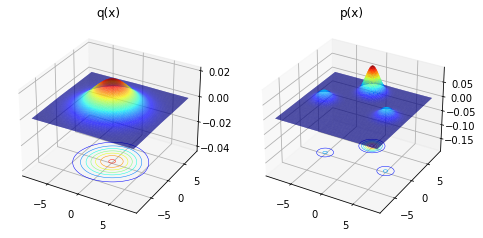

In [10]:
width = 8
fig_before_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

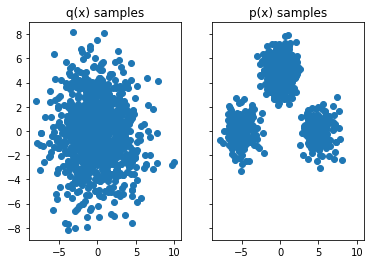

In [11]:
samples_fig_before = plot_samples(tester) 

In [12]:
history = tester.train(epochs, batch_size=batch_size, KPI_batch_size=KPI_n_samples,
                       clip_grad=True, max_grad_norm=1)

loss: -0.6093068752079027, mean log p_x -5.7998911033035325: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:09<00:00,  1.09s/it]


In [13]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 27.00068092915432 
estimate before training is 26.96192585851744 
estimate after training is 27.003831527156205 
effective sample size before is 0.09806445919695442
effective sample size after train is 0.49622848211721604
variance in weights is 1.0152017463919928e-12


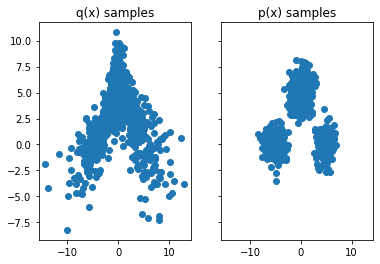

In [14]:
samples_fig_after = plot_samples(tester)

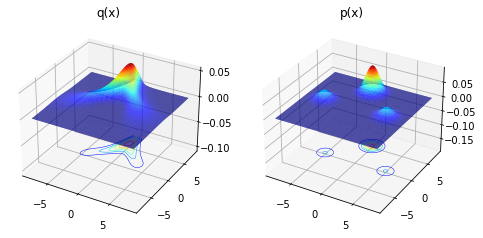

In [15]:
width = 8
fig_after_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

In [16]:
plot_divergences(history)

In [17]:
plot_sampling_info(history)

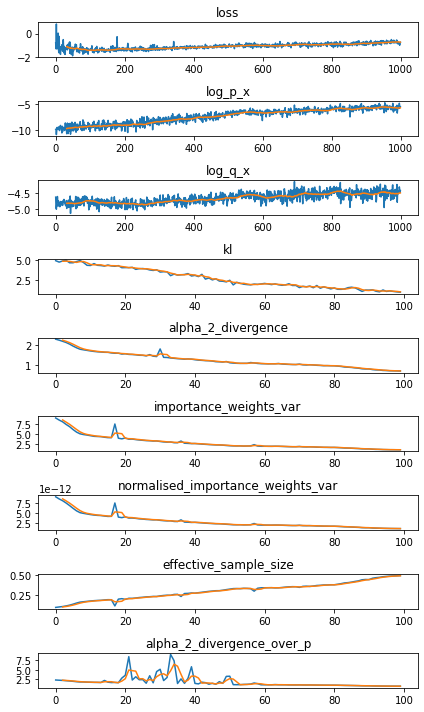

In [18]:
hist_plot = plot_history(history)

# KL

In [40]:
epochs = int(1e4)
batch_size = int(1e2)
dim = 2
n_samples_estimation = int(1e6) 
KPI_n_samples = int(1e4) # slows down training a lot

In [41]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

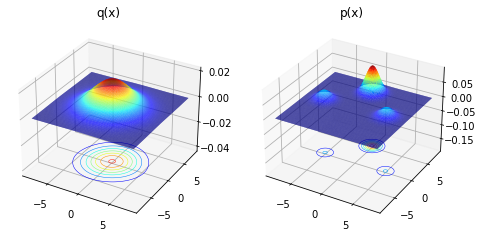

In [42]:
width = 8
fig_before_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

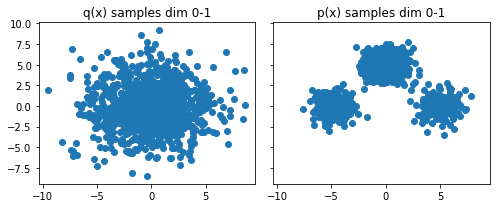

In [43]:
samples_fig_before = plot_samples(tester) 

In [44]:
history = tester.train(epochs, batch_size=batch_size, KPI_batch_size=KPI_n_samples, 
                       clip_grad=True, max_grad_norm=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [45]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 63.818075866461186 
estimate before training is 63.646295362525166 
estimate after training is 78.48797177945112 
effective sample size before is 0.09806770369128852
effective sample size after train is 0.00037590400147041974
variance in weights is 2.6592563306413063e-09


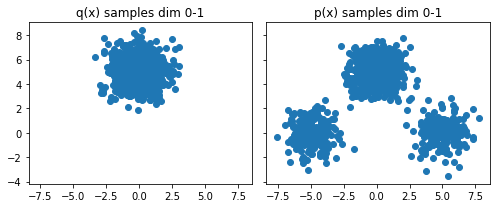

In [46]:
samples_fig_after = plot_samples(tester)

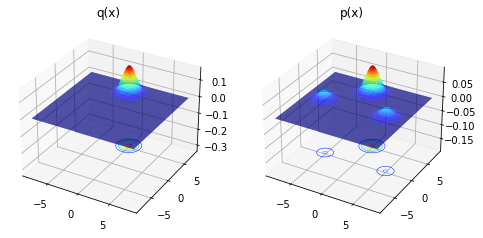

In [47]:
width = 8
fig_after_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

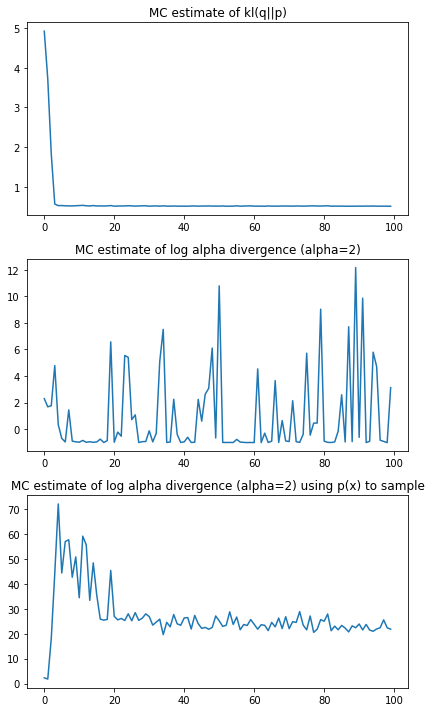

In [48]:
plot_divergences(history)

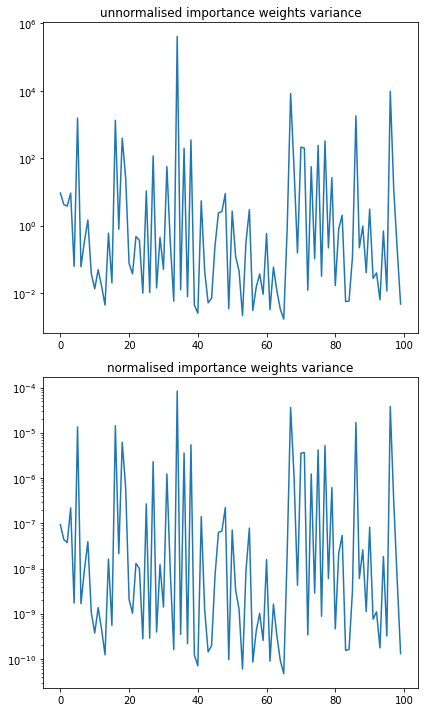

In [49]:
plot_sampling_info(history)

In [50]:
hist_plot = plot_history(history)

# KL with annealing

In [28]:
epochs = int(1e4)
batch_size = int(1e2)
dim = 2
n_samples_estimation = int(1e6) 
KPI_n_samples = int(1e4) # slows down training a lot

In [29]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl", lr=1e-3, annealing=True)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

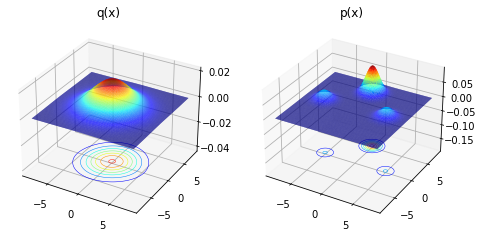

In [30]:
width = 8
fig_before_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

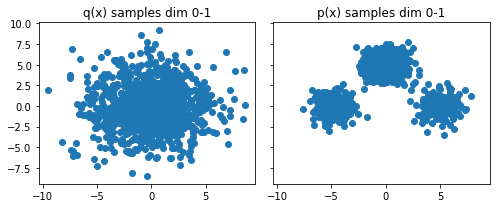

In [31]:
samples_fig_before = plot_samples(tester) 

In [32]:
tester.to("cpu")

In [33]:
history = tester.train(epochs, batch_size=batch_size, KPI_batch_size=KPI_n_samples, 
                       clip_grad=True, max_grad_norm=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [35]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 63.818075866461186 
estimate before training is 63.646295362525166 
estimate after training is 63.77580411824043 
effective sample size before is 0.09806770369128852
effective sample size after train is 0.48905479231174764
variance in weights is 1.0447617049589955e-12


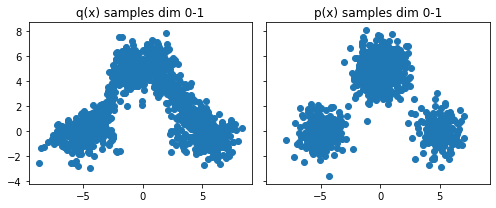

In [34]:
samples_fig_after = plot_samples(tester)

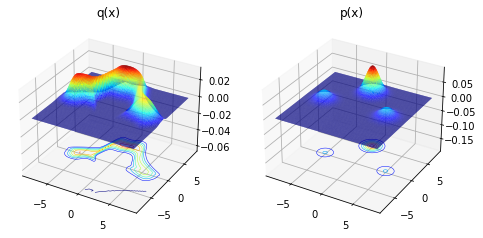

In [36]:
width = 8
fig_after_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

In [37]:
plot_divergences(history)

In [38]:
plot_sampling_info(history)

In [39]:
hist_plot = plot_history(history)